In [1]:
# Import necessary libraries
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import pickle 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model

In [2]:
file_path = r"C:\Users\tmbha\OneDrive\Desktop\DEEP_dfaudio\uploads\C_06506_0_A.wav"

def plot_mel_spectrogram(file_path):
    import librosa.display

    signal, sr = librosa.load(file_path, sr=16000)
    S = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()


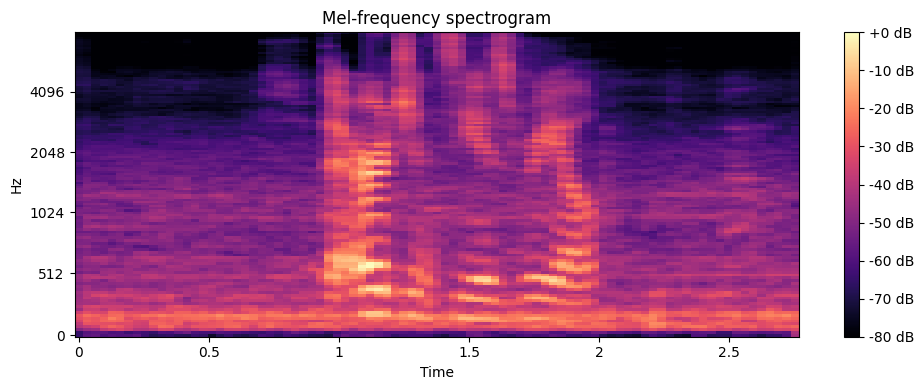

In [4]:
file_path = r"C:\Users\tmbha\OneDrive\Desktop\DEEP_dfaudio\uploads\C_06506_0_A.wav"
plot_mel_spectrogram(file_path)

In [2]:
# Function to load and extract MFCC features from the dataset
def load_data(database_path, max_samples=2400):
    audio_data = []
    labels = []

    for label in ['real', 'fake']:
        dir_path = os.path.join(database_path, 'train', label)
        files = [f for f in os.listdir(dir_path) if f.endswith('.wav')][:max_samples]  # Limit samples
        
        for file_name in files:
            file_path = os.path.join(dir_path, file_name)
            signal, sr = librosa.load(file_path, sr=16000)
            
            # Extract MFCCs
            mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13).T  # Shape = (time_steps, features)
            
            audio_data.append(mfccs)
            labels.append(0 if label == 'real' else 1)

    # Pad MFCC sequences to ensure uniform shape
    max_len = max(mfcc.shape[0] for mfcc in audio_data)
    audio_data = [np.pad(mfcc, ((0, max_len - mfcc.shape[0]), (0, 0)), mode='constant') for mfcc in audio_data]

    return np.array(audio_data), np.array(labels)

In [3]:

# Attention Mechanism for feature extraction
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                 initializer="glorot_uniform",
                                 trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer="zeros",
                                 trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer="glorot_uniform",
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        score = K.tanh(K.dot(inputs, self.W) + self.b)
        attention_weights = K.softmax(K.dot(score, self.u), axis=1)
        context_vector = attention_weights * inputs
        context_vector = K.sum(context_vector, axis=1)
        return context_vector


In [4]:
# Function to plot training metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [5]:
# Load the dataset
database_path = r'C:\Users\tmbha\OneDrive\Desktop\Deepfake_audio\Audio_Sample'
X, y = load_data(database_path)

# Split the dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_eval, y_val, y_eval = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [6]:
# Build the CNN + LSTM + Attention deepfake audio detection model
model = models.Sequential([
    layers.Input(shape=(X.shape[1], X.shape[2])),  # (time_steps, features)

    # Convolutional Layers for Feature Extraction
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),

    # LSTM for Sequential Processing
    layers.LSTM(128, return_sequences=True),
    
    # Attention Mechanism
    Attention(),
    
    # Fully Connected Layers
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.7),
    layers.Dense(1, activation='sigmoid')
])

In [7]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)


Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 19s 159ms/step - accuracy: 0.7043 - loss: 0.5586 - val_accuracy: 0.9444 - val_loss: 0.1682
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.9418 - loss: 0.1729 - val_accuracy: 0.9875 - val_loss: 0.0391
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.9712 - loss: 0.0871 - val_accuracy: 0.9889 - val_loss: 0.0247
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.9909 - loss: 0.0391 - val_accuracy: 1.0000 - val_loss: 0.0033
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.9866 - loss: 0.0455 - val_accuracy: 0.9986 - val_loss: 0.0024
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - accuracy: 0.9936 - loss: 0.0211 - val_accuracy: 0.9722 - val_loss: 0.0700
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - accuracy: 0.9806 - loss: 0.0540 - val_accuracy: 0.9972 - val_loss: 0.0080
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.9927 - loss: 0

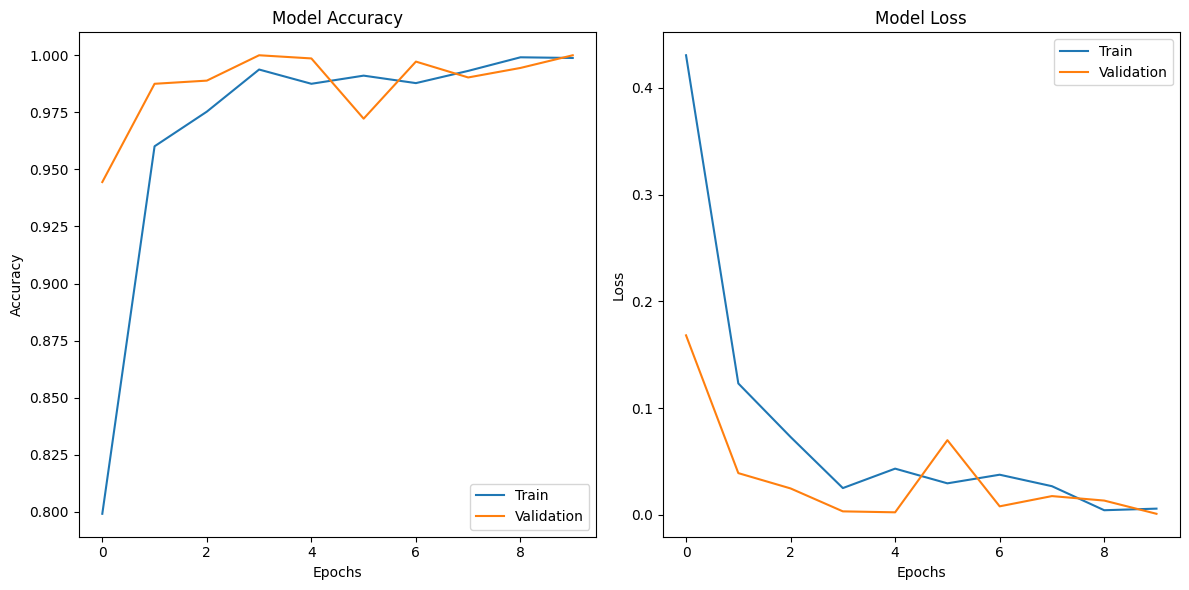

In [8]:
# Plot training metrics
plot_metrics(history)

In [9]:
from sklearn.metrics import classification_report, roc_auc_score

# Evaluate on test data
y_pred = model.predict(X_eval)
y_pred_classes = (y_pred > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_eval, y_pred_classes))

# AUC-ROC score
print("AUC-ROC Score:", roc_auc_score(y_eval, y_pred))

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       371
           1       1.00      1.00      1.00       349

    accuracy                           1.00       720
   macro avg       1.00      1.00      1.00       720
weighted avg       1.00      1.00      1.00       720

AUC-ROC Score: 0.9999922767398574


In [ ]:
# Save the model architecture
save_path = r"C:\Users\tmbha\OneDrive\Desktop\DEEP_dfaudio\model_structure1.png"
plot_model(model, to_file=save_path, show_shapes=True, show_layer_names=True)
print(f"Model plot saved at: {save_path}")

# Save the trained model
model_save_path = r"C:\Users\tmbha\OneDrive\Desktop\DEEP_dfaudio\deepfake_model1.h5"
model.save(model_save_path)

Model plot saved at: C:\Users\tmbha\OneDrive\Desktop\DEEP_dfaudio\model_structure.png


In [ ]:
# Save the preprocessing function
preprocess_save_path = r"C:\Users\tmbha\OneDrive\Desktop\DEEP_dfaudio\preprocessing1.pkl"
with open(preprocess_save_path, 'wb') as f:
    pickle.dump(load_data, f)  # Save the function that extracts MFCC features

print(f"Model saved at: {model_save_path}")
print(f"Preprocessing function saved at: {preprocess_save_path}")

Model saved at: C:\Users\tmbha\OneDrive\Desktop\DEEP_dfaudio\deepfake_model.h5
Preprocessing function saved at: C:\Users\tmbha\OneDrive\Desktop\DEEP_dfaudio\preprocessing.pkl
